In [2]:
import SimpleITK as sitk
import os
import shutil
import numpy as np
import nibabel as nib
from scipy.ndimage import zoom
import pydicom
import cv2
import matplotlib.pyplot as plt
import scipy.interpolate as spi

In [3]:
# for relative paths
import sys
base_path = os.getcwd()


# Standardize Spacing and Dimensions


In [3]:

# Standardize the spacing

def clone_directory_structure(src, dst):
    """
    Clone the directory structure from src to dst.
    """
    for root, dirs, files in os.walk(src):
        # Create the corresponding directory in the destination
        dst_dir = root.replace(src, dst, 1)  # Replace src with dst in the path
        os.makedirs(dst_dir, exist_ok=True)  # Create the directory if it doesn't exist

def monotonic_zoom_interpolate(image_np, resize_factor):
    """
    Apply monotonic zoom interpolation to a given image.
    """
    result = image_np.copy()
    
    for axis, factor in enumerate(resize_factor[::-1]):
        # Create a new array for the interpolated values
        new_length = int(result.shape[axis] * factor)
        x_old = np.arange(result.shape[axis])
        x_new = np.linspace(0, result.shape[axis] - 1, new_length)
        
        # Perform monotonic interpolation
        pchip_interp = spi.PchipInterpolator(x_old, result.take(indices=x_old, axis=axis), axis=axis)
        result = pchip_interp(x_new)

    return result

def process_single_slice_dicom(dicom_file, target_resolution, output_dir):
    """
    Load and standardize the spacing of a single-slice DICOM file.
    """
    
    # Load the DICOM file
    image = sitk.ReadImage(dicom_file)
    current_spacing = np.array(image.GetSpacing())

    resize_factor = np.array([current_spacing[0] / target_resolution[0], 
                               current_spacing[1] / target_resolution[1], 
                               1.0])

    new_real_shape = np.array(image.GetSize()) * resize_factor

    new_shape = np.round(new_real_shape).astype(int)
    
    real_resize_factor = new_shape / np.array(image.GetSize())
    
    image_np = sitk.GetArrayFromImage(image)

    # image_resampled_np = zoom(image_np, real_resize_factor[::-1], order=1)
    image_resampled_np = monotonic_zoom_interpolate(image_np, real_resize_factor)

    image_resampled = sitk.GetImageFromArray(image_resampled_np)

    new_spacing = np.array([target_resolution[0], target_resolution[1], current_spacing[2]])

    image_resampled.SetSpacing(new_spacing)
    
    output_file = os.path.join(output_dir, os.path.basename(dicom_file))
    sitk.WriteImage(image_resampled, output_file)

    print(f"Saved: {output_file}")
    print(f"Original shape: {image_np.shape}, Resampled shape: {image_resampled_np.shape}")
    print(f"Original spacing: {current_spacing}, New spacing: {image_resampled.GetSpacing()}")

def process_mask_dicom(dicom_file, target_resolution, output_dir):
    # Load the DICOM file
    image = sitk.ReadImage(dicom_file)
    current_spacing = np.array(image.GetSpacing())

    resize_factor = np.array([current_spacing[0] / target_resolution[0], 
                               current_spacing[1] / target_resolution[1], 
                               1.0])

    new_real_shape = np.array(image.GetSize()) * resize_factor

    new_shape = np.round(new_real_shape).astype(int)
    
    real_resize_factor = new_shape / np.array(image.GetSize())
    
    image_np = sitk.GetArrayFromImage(image)

    image_resampled_np = zoom(image_np, real_resize_factor[::-1], order=0)
    # image_resampled_np = monotonic_zoom_interpolate(image_np, real_resize_factor)

    image_resampled = sitk.GetImageFromArray(image_resampled_np)

    new_spacing = np.array([target_resolution[0], target_resolution[1], current_spacing[2]])

    image_resampled.SetSpacing(new_spacing)
    
    output_file = os.path.join(output_dir, os.path.basename(dicom_file))
    sitk.WriteImage(image_resampled, output_file)

    print(f"Saved: {output_file}")
    print(f"Original shape: {image_np.shape}, Resampled shape: {image_resampled_np.shape}")
    print(f"Original spacing: {current_spacing}, New spacing: {image_resampled.GetSpacing()}")


def loop_and_standardize(dataset_path, target_resolution, output_path, search_term="4d"):
    """
    Loop over the dataset, clone the folder structure, and standardize the resolution of single-slice data.
    """
    # Clone the directory structure
    clone_directory_structure(dataset_path, output_path)

    for root, dirs, files in os.walk(dataset_path):
        # print(f"Processing directory: {root}")
        # print(f"Directories: {dirs}")
        # print(f"Files: {files}")
        # Ignore directories with '4d' in their name
        if search_term not in os.path.basename(root):
            if "gt" not in os.path.basename(root):
                for file in files:
                    if search_term not in file:
                        if "gt" not in file:
                            if file.endswith(".nii.gz"):  # Assuming DICOM files are used
                                dicom_file_path = os.path.join(root, file)
                                print(f"Processing: {dicom_file_path}")
                                
                                # Process and save in the corresponding output directory
                                output_dir = root.replace(dataset_path, output_path, 1)
                                process_single_slice_dicom(dicom_file_path, target_resolution, output_dir)
                        elif "gt" in file:
                            if file.endswith(".nii.gz"):
                                dicom_file_path = os.path.join(root, file)
                                print(f"Processing: {dicom_file_path}")
                                
                                # Process and save in the corresponding output directory
                                output_dir = root.replace(dataset_path, output_path, 1)
                                process_mask_dicom(dicom_file_path, target_resolution, output_dir)
            


# Example usage:
dataset_path = os.path.abspath(os.path.join(base_path, "../../../Data/ACDC/database/training"))
output_path = os.path.abspath(os.path.join(base_path, "../../../Data/ACDC/database/train_standardized"))  # New path for standardized data
target_spacing = np.array([1.0, 1.0, 1.0])  # Example target resolution (x, y, z spacing)

loop_and_standardize(dataset_path, target_spacing, output_path)


Processing: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\training\patient001\patient001_frame01.nii.gz
Saved: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\train_standardized\patient001\patient001_frame01.nii.gz
Original shape: (10, 256, 216), Resampled shape: (10, 400, 338)
Original spacing: [ 1.5625  1.5625 10.    ], New spacing: (1.0, 1.0, 10.0)
Processing: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\training\patient001\patient001_frame01_gt.nii.gz
Saved: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\train_standardized\patient001\patient001_frame01_gt.nii.gz
Original shape: (10, 256, 216), Resampled shape: (10, 400, 338)
Original spacing: [ 1.5625  1.5625 10.    ], New spacing: (1.0, 1.0, 10.0)
Processing: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\training\patient001\patient001_frame12.nii.gz
Saved: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\train_standardized\patient001\patient

In [4]:

def check_unified_resolution(output_path):
    """
    Check if all images in the output directory have unified resolution.
    """
    resolutions = set()  # To store unique resolutions

    for root, dirs, files in os.walk(output_path):
    
        for file in files:
            # print(file)
            if file.endswith(".nii.gz"):  # Check for NIfTI files
                nifti_file_path = os.path.join(root, file)
                try:
                    image = sitk.ReadImage(nifti_file_path)
                    spacing = image.GetSpacing()  # Get the spacing (resolution)
                    resolutions.add(spacing)  # Add to the set of unique resolutions

                except Exception as e:
                    print(f"Failed to read {nifti_file_path}: {str(e)}")

    # Check the number of unique resolutions
    if len(resolutions) == 1:
        print("All images have a unified resolution.")
    else:
        print("There are multiple resolutions in the dataset:")
        for res in resolutions:
            print(res)

# Example usage:
output_path = os.path.abspath(os.path.join(base_path, "../../../Data/ACDC/database/train_standardized"))  # Path where standardized images are saved
check_unified_resolution(output_path)


There are multiple resolutions in the dataset:
(1.0, 1.0, 10.0)
(1.0, 1.0, 5.0)
(1.0, 1.0, 6.5)
(1.0, 1.0, 7.0)


# Normalize

In [5]:
def normalize_file_by_file(dicom_file, output_dir):
    """
    load and normalize single slice dicome file by z-score normalization
    """
    image = sitk.ReadImage(dicom_file)
    image_np = sitk.GetArrayFromImage(image)
    mean = image_np.mean()
    std = image_np.std()
    image_np = (image_np - mean) / std
    image = sitk.GetImageFromArray(image_np)
    output_file = os.path.join(output_dir, os.path.basename(dicom_file))
    sitk.WriteImage(image, output_file)
    print(f"Saved: {output_dir}")
    print(f"Mean: {mean}, Std: {std}")
    

def loop_and_normalize(dataset_path, output_path, search_term="4d"):
    """
    Loop over the dataset, clone the folder structure, and standardize the resolution of single-slice data.
    """
    # Clone the directory structure
    # clone_directory_structure(dataset_path, output_path)

    for root, dirs, files in os.walk(dataset_path):
        # Ignore directories with '4d' in their name
        if search_term not in os.path.basename(root):
            if "gt" not in os.path.basename(root):
                for file in files:
                    if search_term not in file:
                        if "gt" not in file:
                            if file.endswith(".nii.gz"):  # Assuming DICOM files are used
                                dicom_file_path = os.path.join(root, file)
                                print(f"Processing: {dicom_file_path}")
                                
                                # Process and save in the corresponding output directory
                                output_dir = root.replace(dataset_path, output_path, 1)
                                normalize_file_by_file(dicom_file_path, output_dir)
# Example usage:
dataset_path = os.path.abspath(os.path.join(base_path, "../../../Data/ACDC/database/train_standardized"))  # Original dataset path
output_path = os.path.abspath(os.path.join(base_path, "../../../Data/ACDC/database/train_standardized"))  # New path for standardized data
loop_and_normalize(dataset_path, output_path)

Processing: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\train_standardized\patient001\patient001_frame01.nii.gz
Saved: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\train_standardized\patient001
Mean: 78.17106128746408, Std: 88.29696082479512
Processing: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\train_standardized\patient001\patient001_frame12.nii.gz
Saved: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\train_standardized\patient001
Mean: 77.97213501746606, Std: 87.14891924330793
Processing: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\train_standardized\patient002\patient002_frame01.nii.gz
Saved: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\train_standardized\patient002
Mean: 90.98246547641259, Std: 85.70664129569138
Processing: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\train_standardized\patient002\patient002_frame12.nii.gz
Saved: d:\study\graduation project\GP-2

In [6]:
def check_image_values(output_path):
    """
    Check the minimum and maximum pixel values of the images in the output directory.
    """
    for root, dirs, files in os.walk(output_path):
        for file in files:
            if file.endswith(".nii.gz"):  # Check for NIfTI files
                nifti_file_path = os.path.join(root, file)
                try:
                    image = sitk.ReadImage(nifti_file_path)
                    image_np = sitk.GetArrayFromImage(image)
                    print(f"Min: {image_np.min()}, Max: {image_np.max()} for: {nifti_file_path}")
                except Exception as e:
                    print(f"Failed to read {nifti_file_path}: {str(e)}")

output_path = os.path.abspath(os.path.join(base_path, "../../../Data/ACDC/database/train_standardized"))  # Path where standardized images are saved
check_image_values(output_path)

Min: -0.8853199539061878, Max: 6.518516607936122 for: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\train_standardized\patient001\patient001_frame01.nii.gz
Min: 0.0, Max: 2.0 for: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\train_standardized\patient001\patient001_frame01_gt.nii.gz
Min: -0.8946999652374169, Max: 10.064485843913184 for: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\train_standardized\patient001\patient001_frame12.nii.gz
Min: 0.0, Max: 2.0 for: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\train_standardized\patient001\patient001_frame12_gt.nii.gz
Min: -1.0615567720419636, Max: 5.264496434954187 for: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\train_standardized\patient002\patient002_frame01.nii.gz
Min: 0.0, Max: 2.0 for: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\train_standardized\patient002\patient002_frame01_gt.nii.gz
Min: -1.065965880912592, Max: 5.331091122770014 

In [7]:
# standardize the Dimension by padding
def process_Dimension_by_padding(dicom_file, target_resolution, output_dir):
    """
    Load and standardize the resolution of a single-slice DICOM file using padding.
    """
    image = sitk.ReadImage(dicom_file)
    constant_val = int(sitk.GetArrayFromImage(image).min())

    current_size = np.array(image.GetSize())
    padding_left_right = target_resolution[0] - current_size[0]
    padding_top_bottom = target_resolution[1] - current_size[1]
    padding_left = int(padding_left_right // 2)
    padding_right = int(padding_left_right - padding_left)
    padding_top = int(padding_top_bottom // 2)
    padding_bottom = int(padding_top_bottom - padding_top)

    transformed = sitk.ConstantPad(image,(padding_left,padding_top,0),(padding_right,padding_bottom,0),constant_val)
    
    
    
    output_file = os.path.join(output_dir, os.path.basename(dicom_file))
    sitk.WriteImage(transformed, output_file)

def loop_and_standardize(dataset_path, target_resolution, output_path, search_term="4d"):
    """
    Loop over the dataset, clone the folder structure, and standardize the resolution of single-slice data.
    """
    # Clone the directory structure
    # clone_directory_structure(dataset_path, output_path)

    for root, dirs, files in os.walk(dataset_path):
        # Ignore directories with '4d' in their name
        if search_term not in os.path.basename(root):
            for file in files:
                if search_term not in file:
                    if file.endswith(".nii.gz"):  # Assuming DICOM files are used
                        dicom_file_path = os.path.join(root, file)
                        print(f"Processing: {dicom_file_path}")
                        
                        # Process and save in the corresponding output directory
                        output_dir = root.replace(dataset_path, output_path, 1)
                        process_Dimension_by_padding(dicom_file_path, target_resolution, output_dir)

# Example usage:
dataset_path = os.path.abspath(os.path.join(base_path, "../../../Data/ACDC/database/train_standardized"))  # Original dataset path
output_path = os.path.abspath(os.path.join(base_path, "../../../Data/ACDC/database/train_standardized"))  # New path for standardized data
target_spacing = np.array([512, 512,1.0])  # Example target resolution (x, y, z spacing)

loop_and_standardize(dataset_path, target_spacing, output_path)

Processing: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\train_standardized\patient001\patient001_frame01.nii.gz
Processing: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\train_standardized\patient001\patient001_frame01_gt.nii.gz
Processing: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\train_standardized\patient001\patient001_frame12.nii.gz
Processing: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\train_standardized\patient001\patient001_frame12_gt.nii.gz
Processing: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\train_standardized\patient002\patient002_frame01.nii.gz
Processing: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\train_standardized\patient002\patient002_frame01_gt.nii.gz
Processing: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\train_standardized\patient002\patient002_frame12.nii.gz
Processing: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\train_s

In [8]:
# check if their is a resolution more than 512x512
def check_Dimension(output_path):
    """
    Check if all images in the output directory have a resolution of 512x512.
    """
    for root, dirs, files in os.walk(output_path):
        for file in files:
            if file.endswith(".nii.gz"):  # Check for NIfTI files
                nifti_file_path = os.path.join(root, file)
                try:
                    image = sitk.ReadImage(nifti_file_path)
                    size = image.GetSize()  # Get the size (resolution)
                    if size[0] == 512 or size[1] == 512:
                        print(f"Resolution is 512x512 for: {nifti_file_path}")
                    else:
                        print(f"Resolution lower 512x512 for: {nifti_file_path}")
                except Exception as e:
                    print(f"Failed to read {nifti_file_path}: {str(e)}")

output_path = os.path.abspath(os.path.join(base_path, "../../../Data/ACDC/database/train_standardized"))  # Path where standardized images are saved
check_Dimension(output_path)

Resolution is 512x512 for: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\train_standardized\patient001\patient001_frame01.nii.gz
Resolution is 512x512 for: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\train_standardized\patient001\patient001_frame01_gt.nii.gz
Resolution is 512x512 for: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\train_standardized\patient001\patient001_frame12.nii.gz
Resolution is 512x512 for: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\train_standardized\patient001\patient001_frame12_gt.nii.gz
Resolution is 512x512 for: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\train_standardized\patient002\patient002_frame01.nii.gz
Resolution is 512x512 for: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\train_standardized\patient002\patient002_frame01_gt.nii.gz
Resolution is 512x512 for: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\train_standardized\patient002\pa

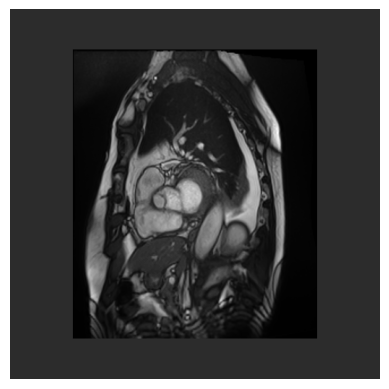

In [9]:
# view on nii image
def view_nii_image(nii_file):
    """
    View a NIfTI image.
    """
    image = sitk.ReadImage(nii_file)
    image_np = sitk.GetArrayFromImage(image)
    plt.imshow(image_np[0], cmap="gray")
    plt.axis("off")
    plt.show()

# Example usage:
nii_file = os.path.abspath(os.path.join(base_path, "../../../Data/ACDC/database/train_standardized/patient001/patient001_frame01.nii.gz"))
view_nii_image(nii_file)


In [16]:

def create_2_channel_numpy_array(patient_root,output_path):
    file_list = [f for f in os.listdir(patient_root) if os.path.isfile(os.path.join(patient_root, f))]
    print(file_list, patient_root)

    # create dictionary for each file with its mask
    file_dict = {}
    mask_dict = {}
    frames_list = []
    for file in file_list:
        if file.endswith(".nii.gz"):
            
            if "gt" in file:
                name_of_frame = file.split("_")[1]
                frames_list.append(name_of_frame)
                # print("proccesing file: ", file)    
                mask_dict[name_of_frame] = file
            else:
                name_of_frame = file.split("_")[1]
                name_of_frame = name_of_frame.split(".")[0]
                
                file_dict[name_of_frame] = file
                # print("proccesing file: ", file)
    
    if file_list[0].endswith(".nii.gz"):
        
    # create a 2 channel numpy array from the mask and the image
        for frame in frames_list:
            image = sitk.ReadImage(os.path.join(patient_root,file_dict[frame]))
            mask = sitk.ReadImage(os.path.join(patient_root,mask_dict[frame]))
            
            image_np = sitk.GetArrayFromImage(image)
            mask_np = sitk.GetArrayFromImage(mask)
            # print(image_np.shape)
            # print(mask_np.shape)
            for slice in range(image_np.shape[0]):
                numpy_array = np.stack((image_np[slice], mask_np[slice]), axis=0)
                # print(numpy_array.shape)
                output_file = os.path.join(output_path, os.path.basename(patient_root),  os.path.basename(patient_root) + f"_{frame}_slice_{slice}_ACDC.npy")
                if not os.path.exists(os.path.join(output_path, os.path.basename(patient_root))):
                    os.makedirs(os.path.join(output_path, os.path.basename(patient_root)))
                # # print(output_file)
                np.save(output_file, numpy_array)        

    

# create a numpy array from nii file where each numpy file has 2 channels one for the mask and the other for the image
def loop_over_data_set_and_create_numpy(dataset_path, output_path, search_term="4d"):
    """
    Loop over the dataset, add in seperate folder, and standardize the resolution of single-slice data.
    """
    

    for folder in os.listdir(dataset_path):
        create_2_channel_numpy_array(os.path.join(dataset_path, folder), output_path)

    
        

dataset_path = os.path.abspath(os.path.join(base_path, "../../../Data/ACDC/database/train_standardized"))  # Original dataset path
output_path = os.path.abspath(os.path.join(base_path, "../../../Data/ACDC/database/train_numpy" )) # New path for standardized data
loop_over_data_set_and_create_numpy(dataset_path, output_path)


['patient001_frame01.nii.gz', 'patient001_frame01_gt.nii.gz', 'patient001_frame12.nii.gz', 'patient001_frame12_gt.nii.gz'] d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\train_standardized\patient001
['patient002_frame01.nii.gz', 'patient002_frame01_gt.nii.gz', 'patient002_frame12.nii.gz', 'patient002_frame12_gt.nii.gz'] d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\train_standardized\patient002
['patient003_frame01.nii.gz', 'patient003_frame01_gt.nii.gz', 'patient003_frame15.nii.gz', 'patient003_frame15_gt.nii.gz'] d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\train_standardized\patient003
['patient004_frame01.nii.gz', 'patient004_frame01_gt.nii.gz', 'patient004_frame15.nii.gz', 'patient004_frame15_gt.nii.gz'] d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\train_standardized\patient004
['patient005_frame01.nii.gz', 'patient005_frame01_gt.nii.gz', 'patient005_frame13.nii.gz', 'patient005_frame13_gt.nii.gz'] d:\study\graduati

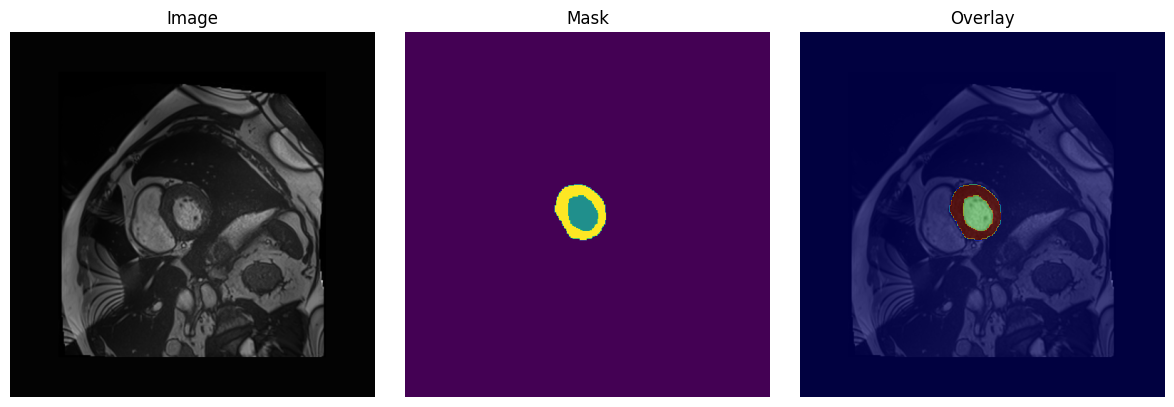

In [5]:
#plot the numpy array mask and image
def plot_numpy_array(numpy_file):
    """
    Plot a 2-channel NumPy array.
    """
    # Load the NumPy array
    numpy_array = np.load(numpy_file)
    
    # Extract the image and the mask
    image = numpy_array[0]
    mask = numpy_array[1]

    # Plot the image, the mask, and the overlay
    plt.figure(figsize=(12, 4))

    # Plot the image
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    # Plot the mask
    plt.subplot(1, 3, 2)
    plt.title("Mask")
    plt.imshow(mask, cmap='viridis')  # Use a different colormap for the mask
    plt.axis('off')

    # Plot the overlay
    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(image, cmap='gray')  # Base image
    plt.imshow(mask, cmap='jet', alpha=0.5)  # Overlay mask with transparency
    plt.axis('off')

    # Show the plots
    plt.tight_layout()
    plt.show()

# Example usage:
numpy_file = os.path.abspath(os.path.join(base_path, "../../../Data/ACDC/database/train_numpy/patient032/patient032_frame01_slice_1_ACDC.npy"))
plot_numpy_array(numpy_file)